In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
#loading data
path = '/content/finitput.txt'
finitput = np.loadtxt(path)
finitput = np.transpose(finitput)

In [3]:
@numba.njit
# functions

def Y_theory(x, a, H):
  return a*x**H

#Hamiltonian
def H_(theta, x, y, Xi, sigma):

  Xi_a, Xi_H = Xi[0], Xi[1]
  a, H = theta[0], theta[1]

  Y_th = Y_theory(x, a, H)
  X = np.sum(((Y_th - y)/sigma)**2 )
  H = X**2 /2 + (Xi_a**2 + Xi_H**2)/2

  return H
# ---

# derivatve functuions for leap frog

def dXda(x, y, theta):
  a, H = theta[0], theta[1]
  return np.sum(-(y - a*x**H) * x**H)

def dXdh(x, y, theta):
  a, H = theta[0], theta[1]
  return np.sum(- a*x**H * np.log(x) * (y - a*x**H))
# ---

# leap frog function for finding new thetas
def leapfrog(x, y, theta0, Xi0, e, sigma):

  Xi, theta = np.zeros((2,6)), np.zeros((2,6))
  Xi[0,0], Xi[1,0] = Xi0[0], Xi0[1]
  theta[0,0], theta[1,0] = theta0[0], theta0[1]

  for j in range(5):
    Xia_tmp, XiH_tmp = Xi[0][j] - e/2 * dXda(x, y, [theta[0][j],theta[1][j]]), Xi[1][j] - e/2 * dXdh(x, y, [theta[0][j],theta[1][j]])
    theta[0][j+1], theta[1][j+1] = theta[0][j] + e * Xia_tmp, theta[1][j] + e * XiH_tmp
    Xi[0][j+1], Xi[1][j+1] = Xi[0][j] - e/2 * dXda(x, y, [theta[0][j+1],theta[1][j+1]]), Xi[1][j] - e/2 * dXdh(x, y, [theta[0][j+1],theta[1][j+1]])

  return theta[0][-1],theta[1][-1], Xi[0][-1], Xi[1][1]
# ---

def Verlet(x, y, theta0, Xi0, e, sigma):

  Xi, theta = np.zeros((2,6)), np.zeros((2,6))
  Xi[0,0], Xi[1,0] = Xi0[0], Xi0[1]
  theta[0,0], theta[1,0] = theta0[0], theta0[1]

  for j in range(5):
    theta[0,j+1], theta[1,j+1] = theta[0,j] + e*Xi[0,j]-1/2 * e**2 * dXda(x,y,theta[:,j])/1000, theta[1,j] + e*Xi[1,j]-1/2 * e**2 * dXda(x,y,theta[:,j])/1000
    Xi[0,j+1], Xi[1,j+1] = Xi[0,j] - 1/2 * e * (dXda(x,y,theta[:,j+1]) + dXda(x,y,theta[:,j]))/1000, Xi[1,j] - 1/2 * e * (dXda(x,y,theta[:,j+1]) + dXda(x,y,theta[:,j]))/1000

  return theta[0][-1], theta[1][-1], Xi[0][-1], Xi[1][-1]


#function for switching theta
def switch(theta_old, theta_new, Xi_old, Xi_new, x, y, sigma):

  delta_H = H_(theta_new, x, y, Xi_new, sigma) - H_(theta_old, x, y, Xi_old, sigma)

  AR = min(1,np.exp(-delta_H/1000))
  r = np.random.random()

  if r<AR:
     return theta_new
  elif r>AR:
     return theta_old

# main HMC function
def HMC(n_step, a_init, H_init, x, y, e, sigma):
  a_o = a_init
  H_o = H_init

  Ham = np.array([])
  a = np.array([])
  H = np.array([])

  for i in range(n_step):
    Xia_o, XiH_o = np.random.normal(0,.001), np.random.normal(0,.001)
    a = np.append(a, a_o)
    H = np.append(H, H_o)
    theta_old, Xi_old = np.array([a_o, H_o]), np.array([Xia_o, XiH_o])
    Ham = np.append(Ham, H_(theta_old, x, y, Xi_old, sigma))
    a_n, H_n, Xi_a_n, Xi_H_n = leapfrog(x, y, theta_old, Xi_old, e, sigma)
    theta_new, Xi_new = np.array([a_n, H_n]), np.array([Xi_a_n, Xi_H_n])
    a_o, H_o = switch(theta_old, theta_new, Xi_old, Xi_new, x, y, sigma)

  return a, H, Ham




In [4]:
x = finitput[0]
y = finitput[1]
a1,H1 = .1,.1
for i in range(5):

  a, H, Ham = HMC(2000, 0.15, 0.7, x, y, 0.0001, 2000)
  print(a[-1], H[-1])

0.14993211976320478 0.7727768874329783
0.14993149222170174 0.7727777286221535
0.1499285681223935 0.7727802217958332
0.1499353181252851 0.7727747536791859
0.14992989085842306 0.7727787693902952


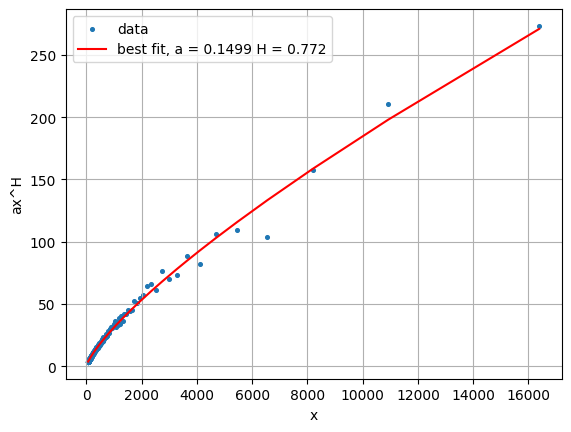

In [18]:
plt.scatter(x, y, label='data', s = 7)
plt.grid()
plt.xlabel('x')
plt.ylabel('ax^H')
plt.plot(x, Y_theory(x, a[Ham.argmin()], H[Ham.argmin()]), label='best fit, a = 0.1499 H = 0.772', color = 'red')
plt.legend()

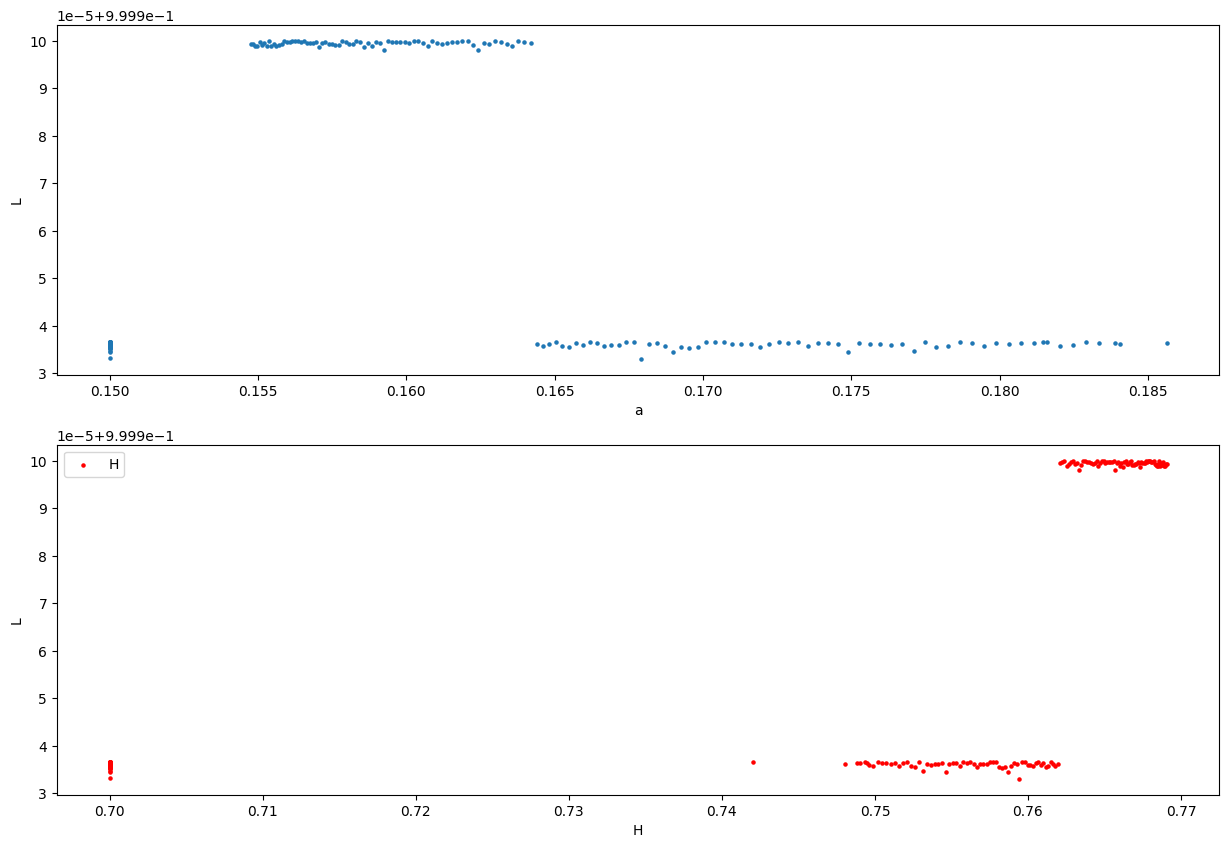

In [17]:
fig, ax = plt.subplots(2)
fig.set_figwidth(15)
fig.set_figheight(10)
ax[0].set(xlabel = 'a', ylabel = 'L')
ax[1].set(xlabel = 'H', ylabel = 'L')
L = np.exp(-(HHam-min(HHam))/2)
ax[1].scatter(H[:200], L[:200], s=5, label = 'H', color ='r')
ax[0].scatter(a[:200], L[:200], s=5, label = 'a')
plt.legend()
